#### **This test for feature importance**

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

import importlib

#### packages
import helper.visualization as viz_hp
import config.config as config_hp

import copy
import helper.stat_helper as stat_hp

Source: https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660

Default impurity based feature importance based on mean decrease in impurity (Gini importance), which measures how effective each feature is at reducing uncertainty.
Overfit model gives wrong interpretation for feature importance.

Ways to reduce overfitting:
- Regularization (min_samples_leaf)

Ways to get feature importance:
- **Permutation importance** (Train the baseline model and record the score (accuracy) on the validation set. Re-shuffle the values for one features, use the model to predict again, and calculate scores on the validation set. The feature importance for the feature is the difference between the baseline and permutation score, repeating the process for all features)
that permutation importances computed on a random forest model spread importance across collinear variables. The amount of sharing appears to be a function of how much noise there is between the two.
- **Drop column importance**  (calculate the model performance with all perdictors and drop a single predictor and see the reduction in the performane, the more important the feature is, the larger the decrease we see in the model performances)

Challenges of feature importance: correlation

#### **Run the model**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [8]:
def run_model(df, 
              columns_not_include,
              y_column = 'replier_label'
             ):
    
    columns_not_include.extend(
        ['poster_tweetid',
         'tweet_label',
         'replier_userid',
         'replier_label']
    )
    
    columns_to_keep = list(set(df.columns) - set(columns_not_include))
    
    df_1 = df.loc[df['replier_label'] == 1]
    df_0 = df.loc[df['replier_label'] == 0]

    df_row = df_0.sample(n=len(df_1))
    df_all = df_1.append(df_row)
    
    X = df_all[columns_to_keep]
    y = df_all[y_column]
       
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, 
                     y, 
                     random_state=104,
                     test_size=0.20, 
                     shuffle=True
                    )

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    print('Xtrain: ', len(X_train))
    print('Xtrain shape: ', X_train.shape)
    print('Xtest: ', len(X_test))
    print('Ytrain: ', len(y_train))
    print('Ytest: ', len(y_test))
    print('Running Random Forest')
 
    return model, X_test, y_test, columns_to_keep
    

In [4]:
importlib.reload(config_hp)

config = config_hp.config()
stat = config['USER_FEATURES']

final_feature = stat['final_feature']

df_stat = pd.read_pickle(final_feature)

#### **Train**

In [9]:
model, X_test, y_test, columns_to_keep = run_model(df_stat, 
                           columns_not_include=[]
                          )

/tmp/ipykernel_813766/556882661.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_1.append(df_row)


Xtrain:  11195
Xtrain shape:  (11195, 76)
Xtest:  2799
Ytrain:  11195
Ytest:  2799
Running Random Forest


In [10]:
print(X_test.shape)
print(len(columns_to_keep))
print(len(y_test))

(2799, 76)
76
2799


#### **Run Feature Importance**

In [20]:
columns_to_keep = list(df_stat.columns)

diff_features = {'Delay': 'diff_min',
                 
                 'Reply_level_like': 'like_count',
                 'Reply_level_retweet':'retweet_count',
                 'Reply_level_reply':'reply_count',
                 
                 'Similarity': 'cosine',
                 
                 'Entites_mention': 'mention',
                 'Entites_hashtags': 'hashtags',
                 'Entites_url': 'url',
                 
                 'Followers rate': 'followers_ratio',
                 'Following rate': 'following_ratio',
                 'Activity rate': 'activity_rate',
                 'Age': 'age'
                }

print('Running the model')

import copy

grp_feat = {}
for feature in diff_features:
    print(f'Removing the feature {feature}')
    
    feat = diff_features[feature]
    matching_test = [col for col in columns_to_keep if feat in col]
    grp_feat[feature] = matching_test

Running the model
Removing the feature Delay
Removing the feature Reply_level_like
Removing the feature Reply_level_retweet
Removing the feature Reply_level_reply
Removing the feature Similarity
Removing the feature Entites_mention
Removing the feature Entites_hashtags
Removing the feature Entites_url
Removing the feature Followers rate
Removing the feature Following rate
Removing the feature Activity rate
Removing the feature Age


In [12]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

def permutation_importance_group(model, X, y, 
                                 feature_groups, 
                                 scoring=f1_score):
    
    scoring = {'f1'}

    scores = cross_validate(model, X, y, scoring=scoring, cv=10,
                            n_jobs=-1
                           )
    mean_1 = round(scores['test_f1'].mean(), 2)
    importances = {}
    
    for group_name, group_features in feature_groups.items():
        print(f'****Starting for {group_name} ****') 
        
        each_score = []
        for i in range(0,10):
            all_score = []
            X_valid_shuffled = X.copy()
            for feature in group_features:
                X_valid_shuffled[feature] = np.random.permutation(
                    X_valid_shuffled[feature]
                )

            shuffled_score = cross_validate(model,
                                            X_valid_shuffled, y, 
                                            scoring=scoring, cv=10,
                                            n_jobs=-1
                                           )
            all_score.extend(shuffled_score['test_f1'])
            
            decrease = mean_1 - np.mean(np.array(all_score))
            
            each_score.append(decrease)
                
        importances[group_name] = each_score
    
    return importances

In [13]:
def plot_permutation_importance(clf, 
                                X, 
                                y, 
                                feature_groups=grp_feat,
                               ):
    results = permutation_importance_group(model, X, y, 
                                 feature_groups, 
                                 scoring=f1_score
                                )
    print(results)
    
    return results

In [21]:
columns_not_include = ['poster_tweetid','tweet_label', 
                       'replier_userid', 'replier_label'
                      ]
columns_to_keep = list(set(df_stat.columns) - set(columns_not_include))

df_1 = df_stat.loc[df_stat['replier_label'] == 1]
df_0 = df_stat.loc[df_stat['replier_label'] == 0]

df_row = df_0.sample(n=len(df_1))
df_all = df_1.append(df_row)

X = df_all[columns_to_keep]
y = df_all['replier_label']

results = plot_permutation_importance(
    model, X, 
    y, feature_groups=grp_feat
)

****Starting for Delay ****
****Starting for Reply_level_like ****
****Starting for Reply_level_retweet ****
****Starting for Reply_level_reply ****
****Starting for Similarity ****
****Starting for Entites_mention ****
****Starting for Entites_hashtags ****
****Starting for Entites_url ****
****Starting for Followers rate ****
****Starting for Following rate ****
****Starting for Activity rate ****
****Starting for Age ****
{'Delay': [0.008148538959478202, 0.011576572062615864, 0.008197167272679606, 0.006230349013766179, 0.013724187341118133, 0.004777332757816111, 0.009662455116454138, 0.007491619901378699, 0.005594743100990951, 0.006169452111797646], 'Reply_level_like': [0.001854488081193928, 0.002212795563100056, 0.005041276612650525, 0.0002927124143727866, 0.00519419116432307, 0.00014519278993974094, 0.003175488653963221, 0.003127161039424564, 0.0038280061824037537, 0.0023189608333878953], 'Reply_level_retweet': [-0.0044343549671828075, -0.0017410165058686644, 0.0007882214858617731

In [44]:
# results

#### **Plot the features**

In [37]:
def assign_color(org_labels):
    colors = {'Delay': 'red', 
              
              'Entities_mention': 'blue', 
              'Entities_hashtags': 'blue', 
              'Entities_url': 'blue', 
              
              'Similarity': 'teal', 
              
              'Reply_level_reply': 'purple',
              'Reply_level_like': 'purple',
              'Reply_level_retweet': 'purple',
              
              'Followers rate': 'green', 
              'Following rate': 'black', 
              'Activity rate': 'orange', 
              'Age': 'yellow'
             }
    
    legends = {'Delay': 'Delay', 
              
              'Entities_mention': 'Entities', 
              'Entities_hashtags': 'Entities', 
              'Entities_url': 'Entities', 
              
              'Similarity': 'Similarity', 
              
              'Reply_level_reply': 'Engagement',
              'Reply_level_like': 'Engagement',
              'Reply_level_retweet': 'Engagement',
              
              'Followers rate': 'Follower_rate', 
              'Following rate': 'Following_rate', 
              'Activity rate': 'Activity_rate', 
              'Age': 'Age'
             }

    all_colors = {}
    for column in org_labels:
        for keys in colors:
            if column == keys:
                all_colors[column] = colors[keys]
    
    return all_colors, legends

In [39]:
def plot_feature_importance(features_score,
                           ax
                           ):
    all_score = []
    org_labels = []
    sort_index = []
    for feat in features_score:
        all_score.append([round(x, 3) for x in features_score[feat]])
        sort_index.append(np.mean(np.array(features_score[feat])))
        org_labels.append(feat)
    index = np.argsort(sort_index)
    labels = [org_labels[i] for i in index]
    labels_colors, legends = assign_color(labels)
    scores = [all_score[i] for i in index]
    
    print(labels_colors)
    
    plots = []
    plot = ax.boxplot(
        scores,
        vert=False,
        labels=labels,
        patch_artist=True
        # color=colors,
        # fontsize=30
    )

    plots.append(plot)
    
    colors = [labels_colors[x] for x in labels]
    index_legends  = [legends[x] for x in labels]
    
    print(colors)
    print(index_legends)
    
    for i, plot in enumerate(plots):
        legend_box = []
        color_test = []
        sel_names = []
        for k, box in enumerate(plot['boxes']):
            box.set(color = colors[k],
                    linewidth=1)
            if colors[k] in color_test:
                continue
            else:
                legend_box.append(box)
                color_test.append(colors[k])
                sel_names.append(index_legends[k])

        ax.legend(legend_box, sel_names, fontsize=24)

    ax.axvline(x=0, color="k", linestyle="--")

    return ax, org_labels

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
results.keys()

dict_keys(['Delay', 'Reply_level_like', 'Reply_level_retweet', 'Reply_level_reply', 'Similarity', 'Entites_mention', 'Entites_hashtags', 'Entites_url', 'Followers rate', 'Following rate', 'Activity rate', 'Age'])

In [31]:
def change_key_name(d, old_key, new_key):
    if old_key in d:
        d[new_key] = d.pop(old_key)
    else:
        print(f"Key '{old_key}' not found in the dictionary.")

# change_key_name(results, 'Entites_mention',  'Entities_mention')
# change_key_name(results, 'Entites_url',      'Entities_url')
# change_key_name(results, 'Entites_hashtags', 'Entities_hashtags')

print(results.keys())


dict_keys(['Delay', 'Reply_level_like', 'Reply_level_retweet', 'Reply_level_reply', 'Similarity', 'Followers rate', 'Following rate', 'Activity rate', 'Age', 'Entities_mention', 'Entities_url', 'Entities_hashtags'])


{'Age': 'yellow', 'Reply_level_retweet': 'purple', 'Following rate': 'black', 'Reply_level_reply': 'purple', 'Entities_url': 'blue', 'Followers rate': 'green', 'Entities_hashtags': 'blue', 'Entities_mention': 'blue', 'Reply_level_like': 'purple', 'Delay': 'red', 'Activity rate': 'orange', 'Similarity': 'teal'}
['yellow', 'purple', 'black', 'purple', 'blue', 'green', 'blue', 'blue', 'purple', 'red', 'orange', 'teal']
['Age', 'Engagement', 'Following_rate', 'Engagement', 'Entities', 'Follower_rate', 'Entities', 'Entities', 'Engagement', 'Delay', 'Activity_rate', 'Similarity']


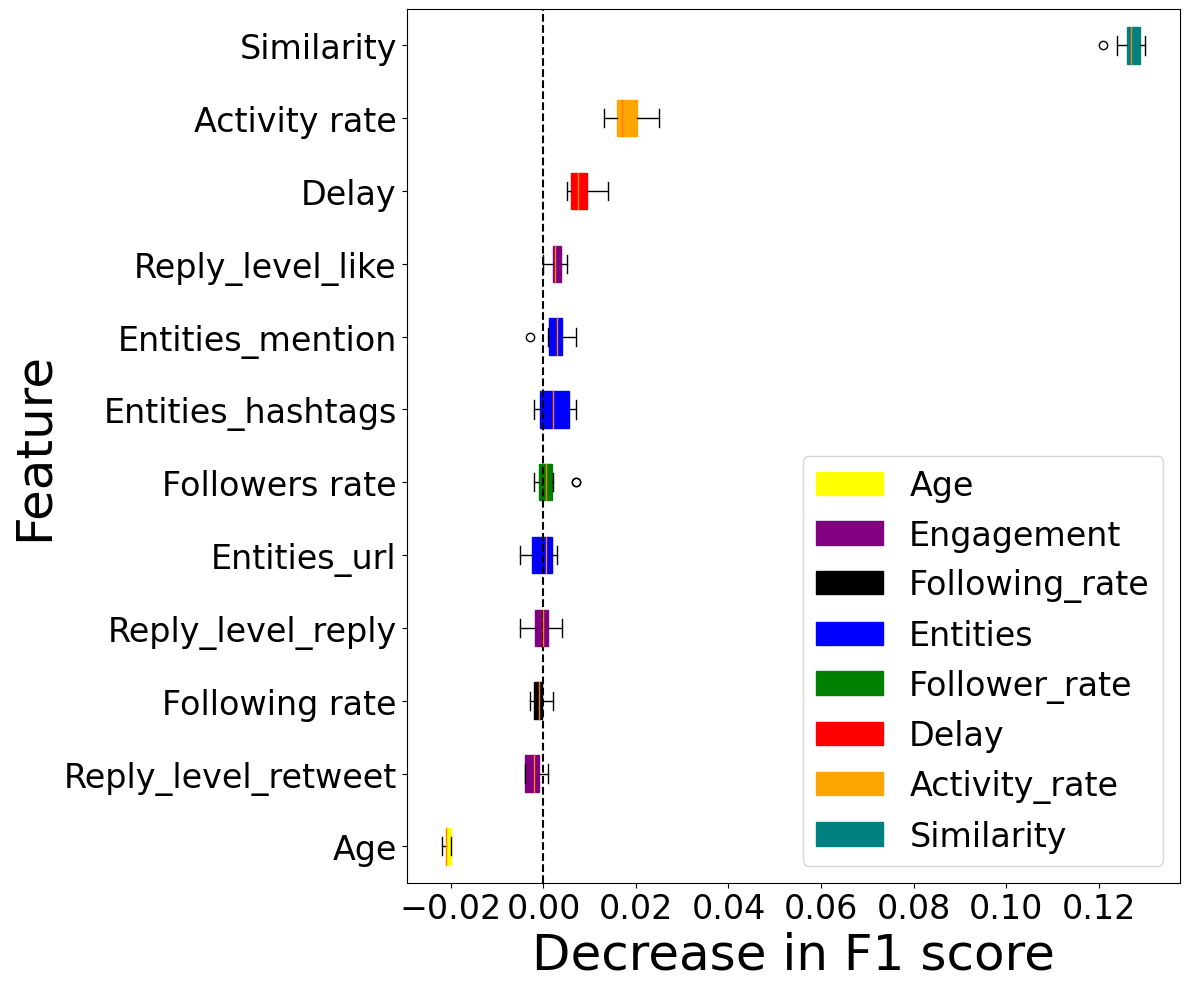

In [41]:
fig, ax = plt.subplots(figsize=(12, 10))

ax, labels = plot_feature_importance(results,
                           ax
                           )

ax.set_xlabel("Decrease in F1 score", fontsize=36)
ax.set_ylabel("Feature", fontsize=36)

plt.yticks(fontsize=24)
plt.xticks(fontsize=24)

ax.figure.tight_layout()

fig.savefig(f'./../plots/replier_feat_importance_grp.png', 
      facecolor='white', 
      transparent=False
           )
plt.show()